<a href="https://colab.research.google.com/github/ivans14/Deep_Learning_Proj/blob/main/CNN_using_VGGM_for_ball_and_player_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball and players detection for SoccerNet
### Using CNN and the pretained model VGGM

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torch.optim as optim
import torch
from torch import nn
from torch.nn import LocalResponseNorm
import pandas as pd
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import cv2
from files.engine import train_one_epoch, 


from sklearn import metrics

In [17]:
# Import dataset as: train, validation and test splits

data = pd.read_csv('proj_test/proj_det/det.txt')
images= ['proj_test/proj_img1/{}.jpg'.format(str(i).zfill(6)) for i in range(750)]
images[1]
int(images[1][-10:-4])

1

In [67]:
# Create image dataset class
class img_dataset():
    def __init__(self, height, width, dir, mode='train') -> None:
        self.height = height
        self.width = width
        self.dir = dir
        self.images=images

    def __getitem__(self,id):
        boxes = []
        labels = []
        img_name = self.images[id]
        print(img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(img_name)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        with open ('proj_test/proj_det/det.txt') as f:
            next(f)
            for line in f:
                line.strip("/n")
                parsed = [float(x) for x in line.split(',')]
                if int(parsed[1]) == int(self.images[id][-10:-4]):
                    x = parsed[3]
                    y = parsed[4]
                    width = parsed[5]
                    height = parsed[6]
                    boxes.append([x,y,width,height])
                    labels.append(parsed[-1])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([id])
        target["image_id"] = image_id
        return self.images[id],boxes
        



In [68]:
img_ds = img_dataset(1920,1080,'proj_test/proj_img1/')
ran_img, boxes = img_ds[20]

proj_test/proj_img1/000020.jpg


proj_test/proj_img1/000200.jpg


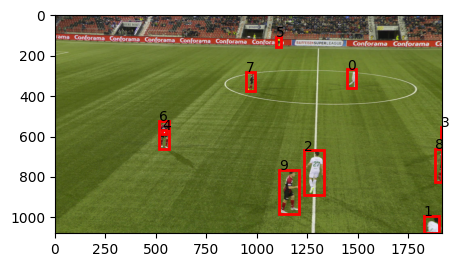

In [72]:
#Visualize the data
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_img_bbox(img, boxes):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  img_plot = mpimg.imread(img)
  a.imshow(img_plot)
  count = 0
  for box in (boxes):
    x, y, width, height  = box[0], box[1], box[2], box[3]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
    a.annotate(str(count), xy=(x,y))
    count += 1
  plt.show()
img_ds = img_dataset(1920,1080,'proj_test/proj_img1/')
ran_img, boxes = img_ds[200]
# img = mpimg.imread(ran_img)
# imgplot = plt.imshow(img)
# plt.show()

plot_img_bbox(ran_img, boxes)

In [7]:
# # CNN model
# out_features = 2 # Ball and players
# image_shape = (400, 400, 3)

# class Model(nn.Module):
#     def __init__(self,out_classes, image_size):
#         super().__init__()
#         self.out_classes = out_classes
#         H = image_size[0]
#         W = image_size[1]
#         C = image_size[2]

#         conv1 = {
#             "in": 1,
#             "out": 16,
#             "kernel": 5,
#             "stride": 2,
#             "padding": 0
#         }
#         conv2 = {
#             "in":conv1["out"],
#             "out": 28,
#             "kernel": 5,
#             "stride": 2,
#             "padding": 0
#         }
#         pool = {
#             "kernel": 2,
#             "stride": 2,
#             "padding": 0
#         }

#         conv_param = [conv1,pool,conv2,pool]

#         for i in range (0, len(conv_param)):
#             H = np.floor((H + 2*conv_param[i]["padding"] - conv_param[i]["kernel"])/conv_param[i]["stride"] + 1)
#             W = np.floor((W + 2*conv_param[i]["padding"] - conv_param[i]["kernel"])/conv_param[i]["stride"] + 1)


#         activation_fn = nn.ReLU(0.1)
#         # Defining a Sequential pipeline for the entire CNN
#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels = conv_param[0]["in"],
#                      out_channels = conv_param[0]["out"],
#                      kernel_size = conv_param[0]["kernel"],
#                      stride= conv_param[0]["stride"],
#                      padding= conv_param[0]["padding"]),
#             activation_fn,
#             LocalResponseNorm(2),   # Check: https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac
#             nn.MaxPool2d(kernel_size = conv_param[1]["kernel"],
#                         stride =conv_param[1]["stride"]),
            
#             nn.Conv2d(in_channels = conv_param[2]["in"],
#                      out_channels = conv_param[2]["out"],
#                      kernel_size = conv_param[2]["kernel"],
#                      stride= conv_param[2]["stride"],
#                      padding= conv_param[2]["padding"]),
#             nn.MaxPool2d(kernel_size = conv_param[3]["kernel"],
#                         stride =conv_param[3]["stride"]),
            
#             #nn.Flatten(), # Flattens a contiguous range of dims into a tensor.
#             # FFNN
#             activation_fn,
#             nn.Linear(int(conv_param[-2]["out"] * H * W), out_features),
#             # nn.Dropout(0.5),
#             # nn.Sigmoid(),
#             # nn.Linear(,self.out_classes),
#             # nn.Dropout(0.25),
#             # nn.Sigmoid()
#         )


#     def forward(self, x):

#       return nn.Softmax(self.net(x))

# NN = Model(out_features, image_shape)
# device = device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # use cuda if possible
# NN.to(device)
# print(NN)

# # Definition of optimizer and loss functions
# optimizer = optim.Adam(NN.parameters(),lr=0.008)
# loss_fn = nn.CrossEntropyLoss() 

Model(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 28, kernel_size=(5, 5), stride=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=16128, out_features=2, bias=True)
  )
)


PRETRAINED MODEL


In [ ]:
## RESNET pre-trained model :)
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

TRAINING


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3 #CLASS ZERO FOR BACKGROUND, 1 FOR PLAYERS AND 2 FOR BALL 

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [ ]:
# training for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

In [ ]:
# Define training function
# HOLA 
# adios

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

# Set number of epochs according to computational power, time and results.
batch_size = 64
num_epochs = 4
validation_every_steps = 500

step = 0
NN.train()

train_accuracies = []
valid_accuracies = []
running_loss = 0



for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    train_loss_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = NN(inputs) # Pass the inouts through the NN
        loss = loss_fn(output,targets) # Compute and Save loss
        optimizer.zero_grad() #Clean up gradients
        loss.backward() # Compute gradients based on the loss from the current batch
        optimizer.step()
        running_loss += loss.item()

        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            validation_loss = 0
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                NN.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = NN(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                NN.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

# Save model (i.e. its weights)
torch.save(NN.state_dict(), 'trained_models/CNN_weights.pth')
print("Finished training.")